In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime
from sklearn.manifold import TSNE

In [ ]:
def noisy_image(image, noise_factor=0.3):
    """add noise to an image

    Args:
        image: original images
        noise_factor: multiplicat factor to noise

    Returns:
      noisy_image
    """

    noisy_image = image + noise_factor * tf.random.normal(shape=image.shape)
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 1.0)

    return noisy_image

def preprocess(image):
    """normalize image

    Args:
        image: original images

    Returns:
      normalized image
    """
    return tf.cast(tf.expand_dims(image, -1), tf.float32)/255.

def prepare_mnist_data(batch_size):
    """preprocess mnist data: add noise to the mnist images and set the original image as the target

    Args:
        batch_size: batch size

    Returns:
      train, test
    """
  # creating the data pipeline
  (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
  
  train = tf.data.Dataset.from_tensor_slices((x_train, x_train))
  test = tf.data.Dataset.from_tensor_slices((x_test, x_test))

  train = train.map(lambda img, target: (noisy_image(preprocess(img)), preprocess(target))).shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  test = test.map(lambda img, target:(noisy_image(preprocess(img)), preprocess(target))).shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  
  return train,test

In [ ]:
#model       
class Encoder(tf.keras.Model):

    # constructor
    def __init__(self):
        super().__init__()

         # basic CNN structure
        self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu') 
        self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

        self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.global_pool = tf.keras.layers.GlobalAvgPool2D()
        self.out = tf.keras.layers.Dense(10)

    @tf.function  
    def call(self, x):
        """
          Compute forward step using a CNN
        """
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = self.pooling(x)
        x = self.convlayer3(x)
        x = self.convlayer4(x)
        x = self.global_pool(x)
        x = self.out(x)

        return x

class Decoder(tf.keras.Model):

    # constructor
    def __init__(self):
        super().__init__()

        #Use a dense layer to restore the dimensionality of the flattened feature maps from the encoder
        self.dense = tf.keras.layers.Dense(784,activation='sigmoid')
        #reshape the resulting vector into feature maps again
        self.reshape = tf.keras.layers.Reshape((28,28,1))
        #Use upsampling or transposed convolutions to mirror your encoder.
        self.convtran = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
        self.convtran2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
        #As an output layer, use a convolutional layer with one filter and sigmoid activation to produce an output image.
        self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3,padding='same', activation='sigmoid')

    @tf.function  
    def call(self, x):
        """
          Compute forward step using transposed convolutions
        """
        x = self.dense(x)
        x = self.reshape(x)
        x = self.convtran(x)
        x = self.convtran2(x)
        x = self.out(x)
        return x

class ConvolutionalAutoencoder(tf.keras.Model):
    # constructor
    def __init__(self):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    @tf.function  
    def call(self, x):
        """
          Compute forward step by calling encoder and decoder
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x




In [ ]:
def visualize(train_losses, test_losses):
   """visualize train and etst loss

    Args:
        train_losses: losses from train step
        test_losses: loss from test step

  """ 

  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2),("training","test"))
  plt.show()

def print_img(original, decoded_imgs):
  """print orignial and reconstructed images 

    Args:
        original: original images
        decoded_img: reconstructed images

  """
  n = 10
 
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def train_step(model, input, target, loss_function, optimizer, training=True):
    """train step 

    Args:
        model: model of the NN
        input: input data
        target:target of the input
        optimizer: sets the optimizer
        training: set true to activate the training mode

    Returns:
      loss
    """

    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function, training=False):
    """test step 

    Args:
        model: model of the NN
        test_data: data set on which the test is executed
        loss_function: sets the loss function
        training: set true to activate the training mode

    Returns:
      test_loss
    """

    test_loss_aggregator = []
    decoded_imgs = []

    for input,target in test_data: 
        
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        test_loss_aggregator.append(np.mean(sample_test_loss.numpy()))

        #save prediction images for visualization
        decoded_imgs.append(prediction.numpy())

    
    test_loss = np.mean(test_loss_aggregator)
    
    #print image of test data
    x_test = np.squeeze(np.asarray(list(test_dataset.unbatch().map(lambda x, y: y))))
    decoded_imgs = decoded_imgs[0].squeeze()
    print_img(x_test,decoded_imgs)

    return test_loss

In [ ]:
train_dataset,test_dataset= prepare_mnist_data(32)
model = ConvolutionalAutoencoder()

def train_model(num_epochs = 10, learning_rate = 0.001):
    """train model

    Args:
        num_epoch: number of epochs to be trained
        learning_rate: set the learning rate
    """

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = tf.keras.losses.MeanSquaredError()

    train_losses = []
    losses = []
    test_losses = []
    
    test_loss = test(model, test_dataset, loss)
    test_losses.append(test_loss)

    train_loss = test(model, train_dataset, loss)
    train_losses.append(train_loss)
    
    for epoch in range(1,num_epochs):

        print('Epoch:' + str(epoch))

        #training
        for input, target in train_dataset:
            train_loss = train_step(model, input, target, loss, optimizer)
            losses.append(train_loss)
        mean_loss = np.mean(losses)
        train_losses.append(mean_loss)

        
        # testing
        test_loss = test(model, test_dataset, loss)
        test_losses.append(test_loss)
        visualize(train_losses, test_losses)

11490434/11490434 [==============================] - 0s 0us/step


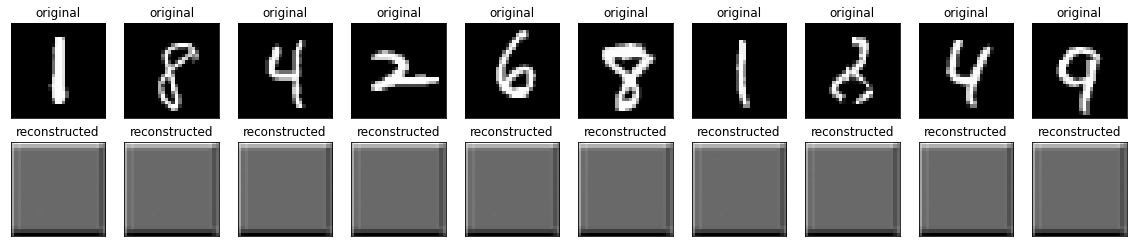

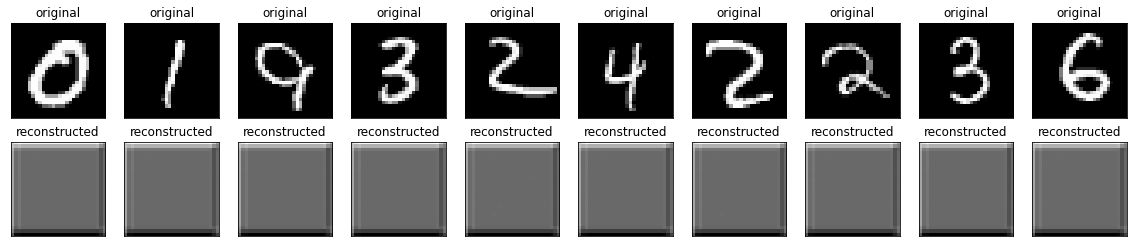

Epoch:1


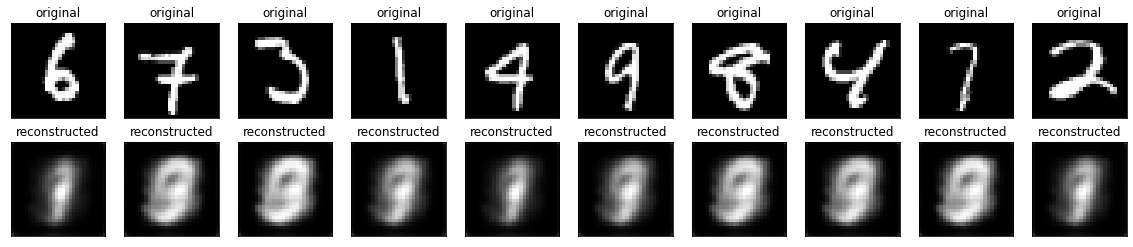

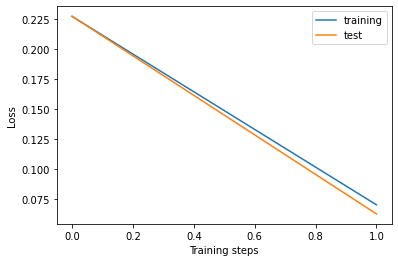

Epoch:2


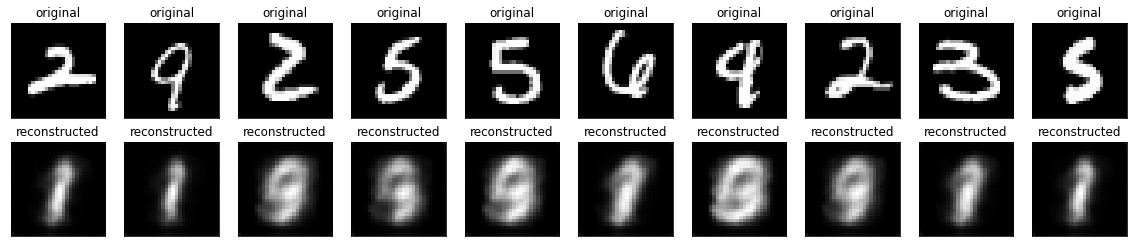

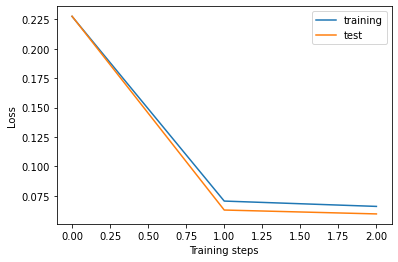

In [ ]:
train_model()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


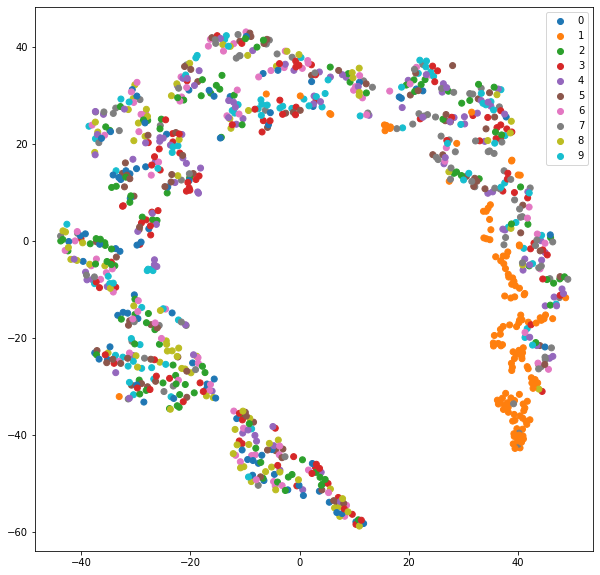

In [ ]:
# Get label names
label_names = [str(l) for l in np.arange(10)]

# Load MNIST dataset
(data, labels), (test_data, test_labels) = tf.keras.datasets.mnist.load_data()

# Select first 1000 test samples and labels
samples = test_data[:1000]
sample_labels = test_labels[:1000]

# Normalize samples and add extra dimension
samples = tf.expand_dims(tf.cast(samples, tf.float32)/255., -1)

# Encode samples
enc = model.encoder(samples)

# Flatten encoded samples
enc = np.reshape(enc, (enc.shape[0], -1))

# Embed samples using t-SNE
embedded = TSNE(n_components=2, perplexity=20).fit_transform(enc)

# Plot embedded samples
fig = plt.figure(figsize=(10, 10))
scatter = plt.scatter(embedded[:,0], embedded[:,1], c=sample_labels, cmap='tab10')
plt.legend(handles=scatter.legend_elements()[0], labels=label_names)


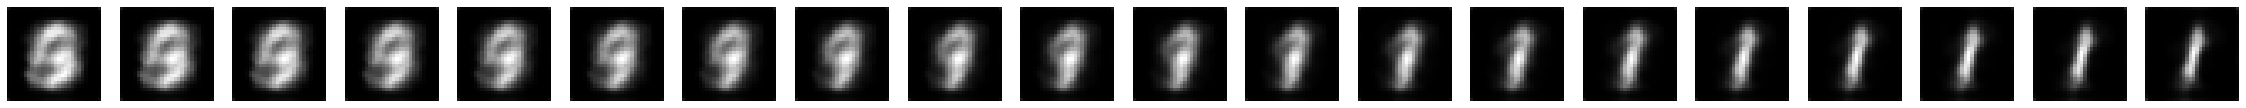

In [ ]:
# Load input tensor
a = samples[2]
b = samples[10]
inputs = tf.convert_to_tensor([a, b])

# Encode inputs
enc = model.encoder(inputs)

# Split encoded tensor into two parts
first, second = enc[0], enc[1]

# Set number of interpolations and create array of factors
n = 20
factors = np.linspace(0, 1, n)

# Create interpolations by combining encoded tensors
interps = []
for i in factors:
    interps.append(first*i + second*(1-i))

# Decode interpolations and store in tensor
recs = model.decoder(tf.convert_to_tensor(interps))

# Plot interpolations
fig = plt.figure(figsize=(2*n,4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(tf.squeeze(recs[i]))
    plt.axis('off')
plt.show()
